# Hodgkin-Huxley model

Exercise 6, https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hodgkin-huxley.html

In [7]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex.hodgkin_huxley import HH
from neurodynex.tools import input_factory, plot_tools

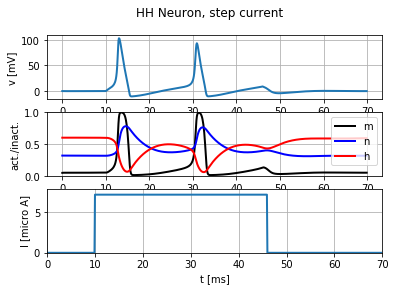

In [1]:
HH.getting_started()

## Q6.1

What's the minimal current step necessary to make a neuron fire at least one spike?

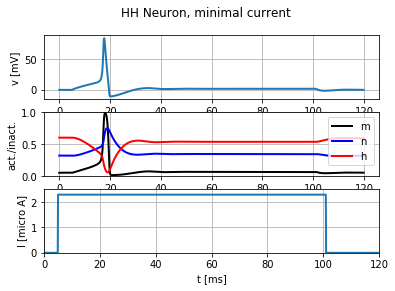

In [39]:
I_min = 2.293
current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

The minimum current to generate one spike is about 2.293 uA.

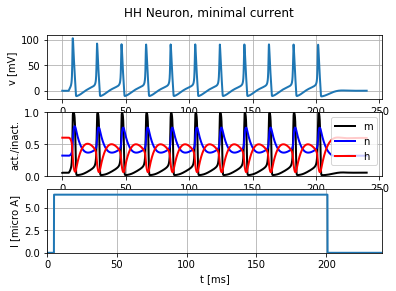

In [57]:
I_min = 6.45
current = input_factory.get_step_current(5, 200, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 240 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

It's about 6.45 uA - below that, there's a regime in which a current step can generate a few spikes, but then the firing putters out. 

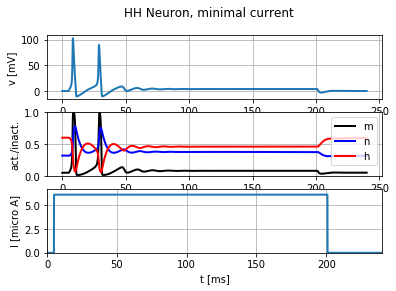

In [69]:
I_min = 6.1
current = input_factory.get_step_current(5, 200, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 240 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

Here $m$ and $h$ are the variables associated with the Na current and $n$ is associated with the K current.

# Q 6.2: slow and fast current ramp

voltage_slow=0.00648049806151452


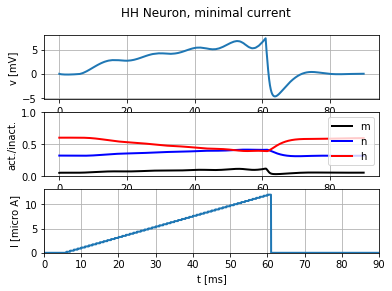

In [77]:
b2.defaultclock.dt = 0.02*b2.ms
slow_ramp_t_end = 60  # no spike. make it shorter
slow_ramp_current = input_factory.get_ramp_current(5, slow_ramp_t_end, b2.ms, 0.*b2.uA, 12.0*b2.uA)
state_monitor = HH.simulate_HH_neuron(slow_ramp_current, 90 * b2.ms)
idx_t_end = int(round(slow_ramp_t_end*b2.ms / b2.defaultclock.dt))
voltage_slow = state_monitor.vm[0,idx_t_end]
print("voltage_slow={}".format(voltage_slow))
HH.plot_data(state_monitor, title="HH Neuron, slow ramp")

voltage_slow=-0.0013394558677867013


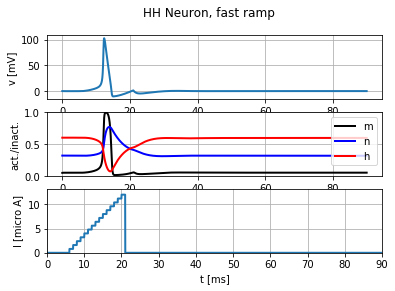

In [86]:
b2.defaultclock.dt = 0.02*b2.ms
slow_ramp_t_end = 20  # no spike. make it shorter
slow_ramp_current = input_factory.get_ramp_current(5, slow_ramp_t_end, b2.ms, 0.*b2.uA, 12.0*b2.uA)
state_monitor = HH.simulate_HH_neuron(slow_ramp_current, 90 * b2.ms)
idx_t_end = int(round(slow_ramp_t_end*b2.ms / b2.defaultclock.dt))
voltage_slow = state_monitor.vm[0,idx_t_end]
print("voltage_slow={}".format(voltage_slow))
HH.plot_data(state_monitor, title="HH Neuron, fast ramp")

The time constant for the $h$ variable depends sensitively on the voltage inside the cell. By increasing the current slowly, h continues to integrate slowly, which delays the initiation of a spike.

# Rebound spike

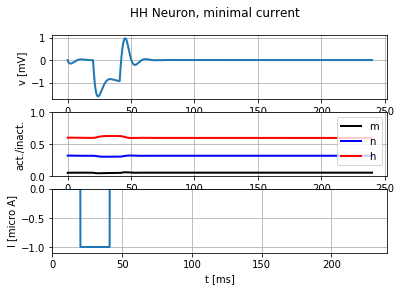

In [88]:
I_min = -1
current = input_factory.get_step_current(20, 40, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 240 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

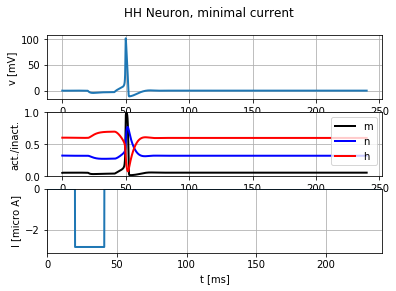

In [107]:
I_min = -2.85
current = input_factory.get_step_current(20, 40, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 240 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

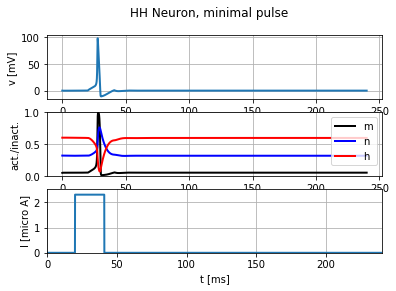

In [99]:
I_min = 2.3
current = input_factory.get_step_current(20, 40, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 240 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal pulse")

There are rebound spikes when there's a decrease in the current. The neuron acts as a bandpass filter rather than a pure low-pass filter. This is most obvious in the spike-response model approximation in Kistler, Gerstner & Hemmen (1997). See figure 1B in particular (solid line):

![SRM model](images/srm.png)

As such, it's sensitive to increments in current regardless of baseline. However, since the threshold is approximately at the same spot under both conditions, and the neuron is closer to the threshold in the non-rebound case, the amount of current necessary to cause a spike is smaller (2.3 uA vs. v.85 uA). 

# Question 2.4

In [109]:
HH.simulate_HH_neuron??

Signature: HH.simulate_HH_neuron(input_current, simulation_time)
Source:   
def simulate_HH_neuron(input_current, simulation_time):

    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = 10.6 * b2.mV
    EK = -12 * b2.mV
    ENa = 115 * b2.mV
    gl = 0.3 * b2.msiemens
    gK = 36 * b2.msiemens
    gNa = 120 * b2.msiemens
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms 

In [128]:
def simulate_HH_neuron(input_current, simulation_time, na_multiplier=1.0):

    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = 10.6 * b2.mV
    EK = -12 * b2.mV
    ENa = 115 * b2.mV
    gl = 0.3 * b2.msiemens
    gK = 36 * b2.msiemens
    gNa = na_multiplier * 120 * b2.msiemens
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
    betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
    betam = 4*exp(-.0556*vm/mV)/ms : Hz
    betan = .125*exp(-.0125*vm/mV)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = 0
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

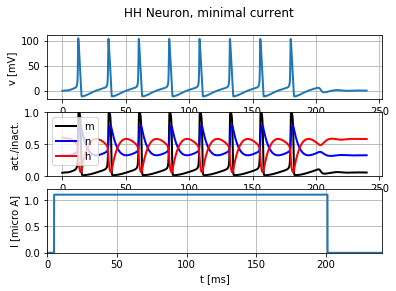

In [129]:
I_min = 1.1
current = input_factory.get_step_current(5, 200, b2.ms, I_min *b2.uA)
state_monitor = simulate_HH_neuron(current, 240 * b2.ms, 1.4)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

1.1 uA is necessary now to make the neuron fire. It's much easier. The gain of the Na current becomes higher, so it becomes easier to make the neuron fire.

In [130]:
I_min = 1.1 * 0.0
current = input_factory.get_step_current(5, 200, b2.ms, I_min *b2.uA)
state_monitor = simulate_HH_neuron(current, 240 * b2.ms, 1.4)
state_monitor.vm.ravel()[-1]

0.45983293 * mvolt

The baseline voltage is .45 mV above the starting voltage.

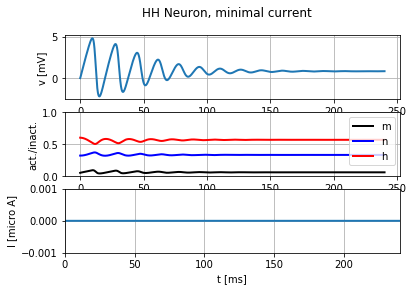

In [140]:
I_min = 1.1 * 0.0
current = input_factory.get_step_current(5, 200, b2.ms, I_min *b2.uA)
state_monitor = simulate_HH_neuron(current, 240 * b2.ms, 1.67)
#state_monitor.vm.ravel()[-1]
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

What happens is beyond a certain conductance, the resting potential becomes high enough that it surpasses the threshold. This initiates self-sustaining spiking.